# Online Appendix

This online appendix accompanies the seminar paper. The purpose of this notebook is to demonstrate a potential Python implementation of the "reliabilitydiag" R package. The R package and the respective paper "Stable reliability diagrams for probabilistic classifiers" (Dimitriadis et al., 2021) are the foundation of this implementation. All interlectual propertiy rights are with the original authors. This notebook solely provides a translation from R into Python. <br>
Dimitriadis, Timo, Tilmann Gneiting, and Alexander I. Jordan (2021). “Stable reliability diagrams for probabilistic classifiers”. In: Proceedings of the National Academy of Sciences 118.8. doi: 10.1073/pnas.2016191118. url: https://www.pnas.org/doi/abs/10.1073/pnas.2016191118.

## Import Packages

In [1]:
import sys; print(sys.executable)

/Users/peterrumpel/opt/anaconda3/bin/python


Load the necessary functions from the python script "functions.py"

In [2]:
from functions import calc_prep
from functions import calc_Score_Decomp
from functions import plot_diagram

Load standard packages for importing the data. All other relevant packages are already loaded when importing "functions".

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data Preparation

Load the data and extract the relevant columns

In [4]:
data = pd.read_csv('precip_Niamey_2016.csv')
x = np.array(data.loc[:, 'EMOS'])
y = np.array(data.loc[:, 'obs'])

Briefly inspect the predicted scores in "x" and the observed outcomes in "y":

In [5]:
def calc_stats(var):
    mean = np.mean(var)
    std = np.std(var)
    quantiles = np.quantile(x, q = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])
    out = [mean, std, quantiles]
    return(out)
calc_stats(var = x)

[0.5166237176104631,
 0.11772158769858716,
 array([0.19623371, 0.22639333, 0.32802366, 0.42895672, 0.45678924,
        0.48560698, 0.57078198, 0.65623393, 0.73832135, 0.88398883,
        0.92264338])]

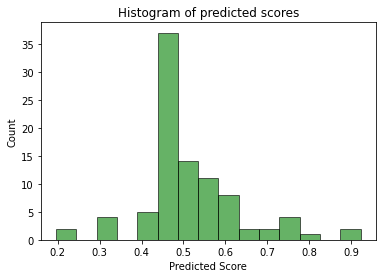

In [6]:
plt.hist(x, bins = 15, color = 'green', edgecolor = "black", alpha = 0.6)
plt.title("Histogram of predicted scores")
plt.xlabel("Predicted Score")
plt.ylabel("Count")
plt.show()

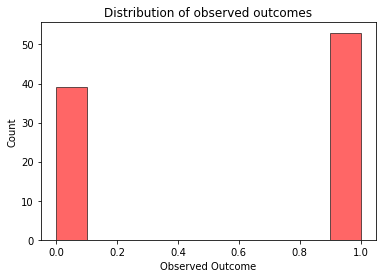

In [7]:
plt.hist(y, color = "red", edgecolor = "black", alpha = 0.6)
plt.title("Distribution of observed outcomes")
plt.xlabel("Observed Outcome")
plt.ylabel("Count")
plt.show()

## Calibration Analysis

### Isotonic Regression and Uncertainty Estimation

In a first step, all relevant calculations are performed by the function calc_prep. It fits an isotonic regression of the observed outcomes on the predicted scores. Further, it computes uncertainty areas, to assess the precision of the isotonic fit. The user can choose between a resampling approach or the usage of asymptotic theory. Both results have to be interpreted with caution, since the isotonic function has kinks and thus the result is not continuous.

In [8]:
iso_out, uncert_out = calc_prep(x = x, y = y, level = 0.1, m = 100, uncertainty = "resampling", type = "confidence")

In [9]:
iso_out.head()

,X,Y,Fit
0,0.196234,0,0.000000
1,0.229376,1,0.333333
2,0.315084,0,0.333333
3,0.315523,0,0.333333
4,0.327749,1,0.333333


In [10]:
uncert_out.head()

,Z,LB,UB
0,0.196234,0.0,0.000000
1,0.229376,0.0,0.375298
2,0.315084,0.0,0.413793
3,0.315523,0.0,0.413937
4,0.327749,0.0,0.438702


### Uncertainty Quantification: CORP Score Decomposition

In [11]:
corp = calc_Score_Decomp(iso_data = iso_out)
corp.T

,Discrimination,Miscalibration,Uncertainty,Frac Positives,Mean Brier Score,Brier Score
Value,0.03047,0.01828,0.24421,0.57609,0.23203,0.21374


### Graphical Analysis

#### Resampling - Confidence
To generate confidence bands around the estimates of the isotonic regression, the data is resampled. Within bootstrapped data set, a hypothetical outcome (0 or 1) is drawn for each unique forecasted score from a Bernoulli distribution with probability parameter equal to the initial isotonic fit of the forecasted scores. Taking each resampled data set to the isotonic regression again, yields new fitted scores for each unique forecasted value. Between the unique values, linear interpolation assures full coverage. Repeating this procedure m times yields a distribution of new fitted values for each original predicted score. Linear interpolation between all lower and upper quantiles of the distributions delivers the confidence region around the estimates. 
The true events are depicted in orange. Since the diagram deals woth binary classification only, the target can either be 0 or 1. The dark blue dots represent the fitted values generated by the isotonic regression. Ideally, those fitted values should gather closely around the 45 degree line, depicted in grey. The confidence region, in this case with a 10% significance level, is shaded in light blue.

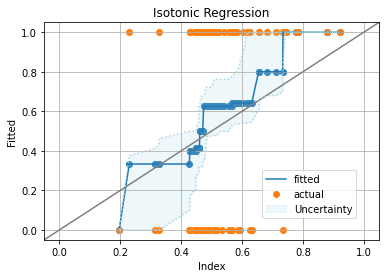

In [12]:
plot_diagram(iso_data = iso_out, uncert_data = uncert_out)

#### Resampling - Consistence
Additionally, the function allows to construct consistence bands around the ideal calibration, i.e. around the 45 degree line. Therefore, the above described procedure is slightly amended. Instead of drawing from a Bernoulli distribution with the parameter equal to the isotonic fit of the predicted score, the predicted score itself is used. It is visible that the fitted scores move quite nicely within this consistncy region.

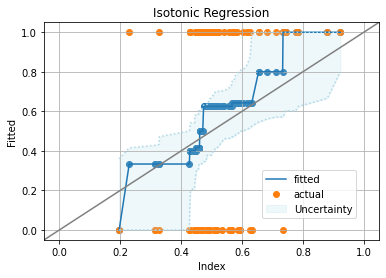

In [13]:
iso_out, uncert_out = calc_prep(x = x, y = y, level = 0.1, m = 100, uncertainty = "resampling", type = "consistency")
plot_diagram(iso_data = iso_out, uncert_data = uncert_out)

#### Discrete Asymptotics
Instead of using a resampling approach, asymptotic theory can be used to construct consisentcy bands as well. As the authors note, this approach is only valid for consistency regions but not for confidence regions. The region is constructed for each unique predict score $z_j$ as follows:
\begin{equation}
z_j \pm\left(\frac{z_j (1-z_j)}{n_j}\right)^\frac{1}{2} * q_{\alpha/2}(N)
\end{equation}
q is the desired quantile of a standard normal distribution and $n_j$ is the amount of observations behind a unique score $z_j$. <br>
It is apparent, that even for a significance level of 10%, the uncertainty is extreme.

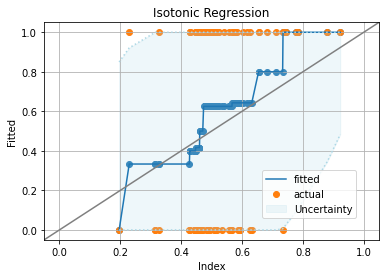

In [14]:
iso_out, uncert_out = calc_prep(x = x, y = y, level = 0.1, m = 100, uncertainty = "discrete", type = "consistency")
plot_diagram(iso_data = iso_out, uncert_data = uncert_out)

#### Continuous Asypmtotics
When considering the distribution of predicted scores as continuous, another formula is applied to construct consistency bands:
\begin{equation}
z_j \pm\left(\frac{z_j (1-z_j)}{2n\widehat{f(z_j)}}\right)^\frac{1}{3} * q_{\alpha/2}(2T)
\end{equation}
$\widehat{f}$ is a kernel density estimate of the unique forecast value and T a Chernhoff distributed random variable. In the original implementation, a bounded density estimate was used. In Python, there is no equivalent option to the $\textit{bde}$ package. Thus, an unbounded density estimation was used. To obtain quantiles of 2T, the distribution function was approximated as implemented in the $\textit{R}$ function of the authors.

Caution: Density Estimation is not bounded!


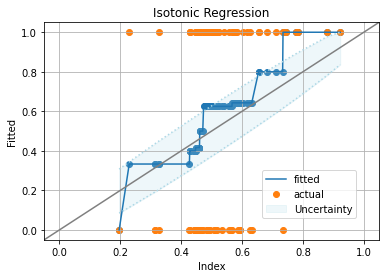

In [15]:
iso_out, uncert_out = calc_prep(x = x, y = y, level = 0.1, m = 100, uncertainty = "continuous", type = "consistency")
plot_diagram(iso_data = iso_out, uncert_data = uncert_out)